# Восстановление пропущенных пробелов в тексте

## Описание задачи
На Авито пользователи часто вводят поисковые запросы и описания без пробелов, что снижает качество поиска и мешает анализу текста.  
Нужно разработать лёгкую и быструю модель, которая принимает строку без пробелов и восстанавливает её правильный вариант.  

Метрика: **F1-score** по позициям вставленных пробелов.

## Подготовка данных
1. Загрузка сырых данных 
2. Первичный анализ данных (EDA)  
3. Основные функции для работы  

In [105]:
def load_dataset_with_summary(path: str) -> pd.DataFrame:
    rows = []
    with open(path, encoding="utf-8") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:  
                continue
            if row[0] == "id":  
                continue
            id_ = int(row[0])  
            text = ",".join(row[1:]) 
            rows.append((id_, text))
    
    df = pd.DataFrame(rows, columns=["id", "text_no_spaces"])
    # df = df.set_index("id")  
    df["length"] = df["text_no_spaces"].str.len()
    
    # Дополнительные признаки
    has_digits = df["text_no_spaces"].str.contains(r"\d").sum()
    has_upper = df["text_no_spaces"].str.contains(r"[А-Я]").sum()
    has_latin = df["text_no_spaces"].str.contains(r"[A-Za-z]").sum()

    # Мини-EDA
    print("Сводка по датасету")
    print("Размер датасета:", df.shape)
    print("Средняя длина:", df["length"].mean())
    print("Мин длина:", df["length"].min())
    print("Макс длина:", df["length"].max())
    print("Строк с цифрами:", has_digits)
    print("Строк с заглавными буквами:", has_upper)
    print("Строк с латиницей:", has_latin)
    print()
    print(df.info())
    
    return df

In [106]:
df = load_dataset_with_summary("Downloads/dataset_1937770_3.txt")
df.head()

Сводка по датасету
Размер датасета: (1005, 3)
Средняя длина: 22.860696517412936
Мин длина: 4
Макс длина: 56
Строк с цифрами: 26
Строк с заглавными буквами: 589
Строк с латиницей: 90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1005 non-null   int64 
 1   text_no_spaces  1005 non-null   object
 2   length          1005 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None


,id,text_no_spaces,length
0,0,куплюайфон14про,15
1,1,ищудомвПодмосковье,18
2,2,сдаюквартирусмебельюитехникой,29
3,3,новыйдивандоставканедорого,26
4,4,отдамдаромкошку,15


In [107]:
# посмотреть строки с 100 по 110, где были запятые в предложениях - убеждаеся что все верно разбито
df.iloc[100:111]

,id,text_no_spaces,length
100,100,"ищукнигубратьякарамазовы,срочно",31
101,101,"новыймонитор,27дюймов,доставка",30
102,102,"куплюковрикдляйоги,недорого!",28
103,103,"ищуинструкторапоплаванию,бассейнрядом",37
104,104,"сдамкомнату,толькодевушке",25
105,105,"куплюшвейнуюмашинку,рабочую",27
106,106,"ищудрузейдляпутешествий,летомвгоры",34
107,107,"новаякофеваркаPhilips,гарантияесть",34
108,108,"куплюлыжи,палкивкомплекте",25
109,109,"ищуучителяповокалу,джаз",23


**Первичный анализ данных (EDA)**

Эти данные помогут определить, где потребуется использовать **эвристики** (например, обработка чисел, брендов, городов).  

Перед построением модели важно изучить данные:
- структура и длины строк,
- наличие лишних символов (цифры, латиница, заглавные буквы),
- потенциальные сложности (бренды, города, спецсимволы).

При загрузке датасета через `pd.read_csv` возникала проблема:  
если в тексте встречаются запятые, Pandas воспринимает их как разделители и создает несколько колонок вместо двух (`id, text_no_spaces`).

Пример строки:  "100,ищукнигубратьякарамазовы,срочно"

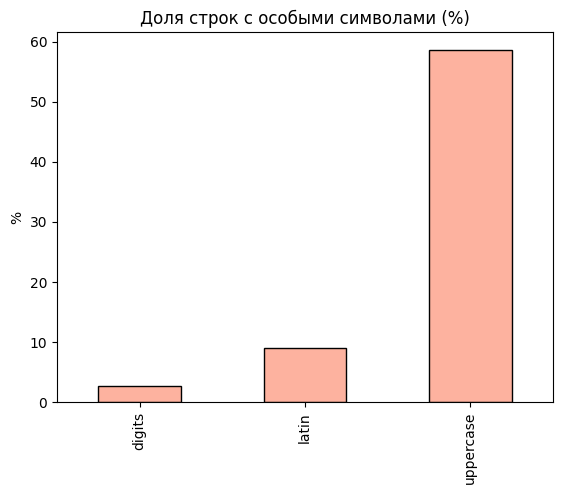

In [108]:
#Частота встречаемости цифр / латиницы / заглавных букв
features = {
    "digits": df["text_no_spaces"].str.contains(r"\d"),
    "latin": df["text_no_spaces"].str.contains(r"[A-Za-z]"),
    "uppercase": df["text_no_spaces"].str.contains(r"[А-Я]")
}
feature_df = pd.DataFrame(features).mean() * 100

feature_df.plot(kind="bar", color="#FDB29F", edgecolor="black")
plt.title("Доля строк с особыми символами (%)")
plt.ylabel("%")
plt.show()

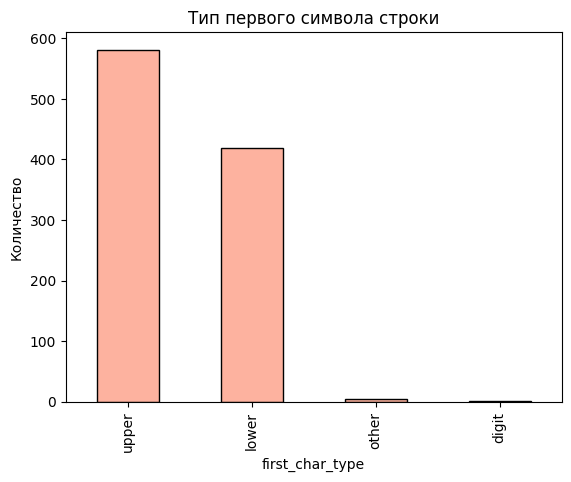

In [109]:
# 1000 lower + 5 other 
df["first_char"] = df["text_no_spaces"].str[0]
df["first_char_type"] = df["first_char"].apply(
    lambda x: "digit" if x.isdigit()
    else "upper" if x.isupper()
    else "lower" if x.islower()
    else "other"
)

df["first_char_type"].value_counts().plot(kind="bar", color="#FDB29F", edgecolor="black")
plt.title("Тип первого символа строки")
plt.ylabel("Количество")
plt.show()

**Основные функции**

In [110]:
#Восстанавливает пробелы в строке по их индексам
def indices_to_text(s_no: str, idxs: set[int]) -> str:
    out = []
    for i, ch in enumerate(s_no):
        if i in idxs: out.append(' ')
        out.append(ch)
    return ''.join(out)

In [111]:
# Возвращает индексы пробелов в строке с пробелами, пересчитанные в координатах строки без пробелов
def space_indices(s_spaced: str) -> list[int]:
    idxs, pos = [], 0
    for ch in s_spaced:
        if ch == " ":
            idxs.append(pos)
        else:
            pos += 1
    return idxs


In [112]:
#Вычисляет F1-score для двух множеств индексов
def f1_sets(gold: set[int], pred: set[int]) -> float:
    tp = len(gold & pred); fp = len(pred - gold); fn = len(gold - pred)
    if tp == 0: return 0.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * precision * recall / (precision + recall)

In [113]:
#Формирует файл для отправки (submission) на основе baseline-предсказаний
def make_submission(baseline_path, out_path):
    df = pd.read_csv(baseline_path)

    df = df[["id", "indices"]].rename(columns={"indices": "predicted_positions"})

    df["predicted_positions"] = df["predicted_positions"].apply(
        lambda x: x.replace(" ", "") if isinstance(x, str) else str(x)
    )
    df.to_csv(out_path, index=False)
    print(f"Submission сохранён в {out_path}")
    return df

## Лексические словари и эвристики

Помимо модели, для восстановления пробелов полезно использовать заранее подготовленные **лексические словари**:
- **Предлоги** (`PREPOSITIONS`) — помогают разделять устойчивые конструкции ("вгороде" → "в городе").
- **Союзы** (`CONJUNCTIONS`) — сигнализируют о месте разрыва ("ичтоб" → "и чтоб").
- **Местоимения** (`PRONOUNS`) 
- **Бренды / модели** (`BRANDS`) — важны для корректного выделения товарных наименований ("куплюiphone14" → "куплю iphone 14").
- **Устойчивые фразы** (`COMMON_PHRASES`) — часто встречающиеся выражения ("срочно продам", "в хорошем состоянии").
- **Специфичные для Авито слова** (`AVITO_WORDS`) — эвристики, выделенные из реальных данных (например, "торг", "срочно", "доставка").
- **Типичные окончания** (`COMMON_ENDINGS`)


Используются для:
1. Для постобработки предсказаний модели (добавление пробелов вокруг найденных слов)
2. Для генерации дополнительных признаков в ML-модели
3. Для анализа покрытия датасета и выявления частых паттернов ошибок


In [115]:
def extract_common_phrases_no_spaces(texts, min_len=8, min_freq=3, topn=20):
    substrs = Counter()
    for t in texts:
        for i in range(len(t) - min_len):
            sub = t[i:i+min_len]
            substrs[sub] += 1
    return [s for s,c in substrs.most_common(topn) if c >= min_freq]
extract_common_phrases_no_spaces(df["text_no_spaces"].tolist())

['квартиру',
 'телевизо',
 'елевизор',
 'куплютел',
 'уплютеле',
 'ищуработ',
 'щуработу',
 'репетито',
 'ищурепет',
 'щурепети',
 'урепетит',
 'епетитор',
 'петитора',
 'етиторап',
 'титорапо',
 'ищусобак',
 'щусобаку',
 'сдамквар',
 'дамкварт',
 'амкварти']

In [118]:
#Специфичные для Авито слова 
def extract_avito_words_no_spaces(texts, min_len=4, max_len=10, topn=50):
    words = Counter()
    for t in texts:
        for w in re.findall(r"[а-яА-ЯёЁ]{%d,%d}" % (min_len, max_len), t):
            words[w.lower()] += 1
    return [w for w,_ in words.most_common(topn)]
extract_avito_words_no_spaces(df["text_no_spaces"].tolist())

['изор',
 'ищурепетит',
 'сдамкварти',
 'весна',
 'куплютелев',
 'сдамкомнат',
 'срочно',
 'сдаюкварти',
 'новыйдиван',
 'куплюноутб',
 'ищуучителя',
 'ищуквартир',
 'ищумастера',
 'куплювелос',
 'доставка',
 'сдамстудию',
 'куплюайфон',
 'куплюгитар',
 'куплюдиван',
 'куплю',
 'новаякуртк',
 'куплюхолод',
 'новыйноутб',
 'ищуработуп',
 'куплютелеф',
 'недорого',
 'хочукупить',
 'естьтолько',
 'помню',
 'пожелаймне',
 'дорого',
 'срочнопрод',
 'новыйтелеф',
 'ищукомнату',
 'ипед',
 'ильник',
 'рочно',
 'куплюкомпь',
 'куплюпылес',
 'куплюмикро',
 'куплюдетск',
 'белый',
 'ский',
 'гарантия',
 'новый',
 'центр',
 'новыйхолод',
 'чтоделать',
 'продаю',
 'хочузаказа']

In [74]:
# Пример извлечения брендов по латинице
brands_list = []
for text in df["text_no_spaces"]:
    brands = re.findall(r"[A-Za-z]{2,}", text)
    brands_list.extend(brands)

brands_list = sorted(set(brands_list))
brands_list[:20]

['Acer',
 'Adidas',
 'Asus',
 'AsusROG',
 'Atlant',
 'Avito',
 'Bosch',
 'Canon',
 'Casio',
 'Dell',
 'Dyson',
 'Fender',
 'Giant',
 'Gibson',
 'HP',
 'Honor',
 'Huawei',
 'IKEA',
 'Ikea',
 'Indesit']

C помощью такого рода анализа можно эвристически восстановить словари для сегментации:

In [119]:
BRANDS = [
    "Apple", "Samsung", "Xiaomi", "Huawei", "Honor", "Nokia", "Sony",
    "LG", "HTC", "Motorola", "Realme", "OnePlus", "Oppo", "Meizu",
    "Google", "Asus", "Lenovo", "Acer", "Dell", "HP", "MSI", "Razer",
    "Microsoft", "Panasonic", "Philips", "Sharp", "Toshiba", "BlackBerry",
    "Canon", "Nikon", "Fujifilm", "Olympus", "Leica", "GoPro", "DJI", 
    "Bosch", "Siemens", "Miele", "Electrolux", "Zanussi", "Indesit",
    "Hotpoint", "Whirlpool", "Beko", "Gorenje", "Kuppersberg", "Haier",
    "Yamaha", "Fender", "Gibson", "Ibanez", "Casio", "Roland", "Korg",
    "Marshall", "Shure", "Sennheiser", "JBL", "Behringer", "AKG",
    "BMW", "Mercedes", "Audi", "Volkswagen", "Skoda", "Porsche",
    "Lexus", "Toyota", "Mazda", "Honda", "Mitsubishi", "Subaru",
    "Suzuki", "Nissan", "Infiniti", "Acura", "Hyundai", "Kia",
    "Peugeot", "Renault", "Citroen", "Opel", "Fiat", "Jeep",
    "Chery", "Geely", "Lada", "UAZ", "Volvo", "Jaguar", "Land Rover",
    "Nike", "Adidas", "Puma", "Reebok", "Under Armour", "New Balance",
    "Columbia", "The North Face", "Patagonia", "Timberland", "Crocs",
    "Converse", "Vans", "Levi's", "Wrangler", "Zara", "H&M", "Uniqlo",
    "IKEA", "Hoff", "Leroy Merlin", "Castorama", "Decathlon"
]

AVITO_WORDS = {
    # Общие действия
    "куплю", "продам", "сдаю", "сдам", "ищу", "отдам", "даром", "срочно", "недорого",
    "новый", "новая", "б/у", "бу", "работа", "удаленно", "доставка", "обмен",

    # Недвижимость
    "квартира", "квартиру", "комната", "комнату", "дом", "гараж", "дача",
    "участок", "земля", "подмосковье", "метро", "центр", "район", "улица", "срок",

    # Мебель
    "диван", "шкаф", "стол", "кровать", "матрас", "кухня", "кухонный", "стул",
    "комод", "тумба", "полка", "угловой", "раскладной", "стенка", "мебель",

    # Бытовая техника
    "техника", "холодильник", "морозильник", "стиральная", "стиральную", "машина",
    "посудомоечная", "плита", "духовка", "микроволновка", "утюг", "чайник",
    "пылесос", "кондиционер", "телевизор", "ноутбук", "монитор", "компьютер",
    "принтер", "сканер",

    # Электроника и телефоны
    "айфон", "iphone", "смартфон", "телефон", "samsung", "xiaomi", "huawei",
    "honor", "nokia", "sony", "philips", "lenovo", "asus", "acer", "hp",
    "dell", "canon", "nikon", "fujifilm", "olympus", "gopro", "панасоник",

    # Музыкальные инструменты
    "гитара", "электрогитара", "бас", "пианино", "синтезатор", "барабан", "скрипка",
    "репетитор", "уроки", "биология", "математика", "физика", "английский", "шкаф"

    # Транспорт
    "авто", "машина", "автомобиль", "мотоцикл", "скутер", "велосипед", "колеса",
    "шины", "резина", "запчасти", "лада", "uaz", "toyota", "honda", "kia",
    "hyundai", "bmw", "audi", "mercedes", "volkswagen", "skoda", "lexus",

    # Животные
    "кошка", "кот", "котенок", "собака", "щенок", "порода", "отдам", "даром",
    "птица", "попугай", "хомяк", "кролик", "рыбка", "аквариум",

    # Услуги
    "грузчик", "переезд", "ремонт", "мастер", "строитель", "уборка", "услуги",
    "подключ", "монтаж", "отделка", "дизайн", "строительство","квартира","квартиру","квартир","ремонт","подключ","ключ","подмосковье",
  "доставка","недорого","кошку","ноутбук","метро","репетитор","биологии",
  "подработка","вечерам","комнату","студентке","собаку","лабрадор","диван","удаленно"
}

COMMON_PHRASES = {"я не", "я уже не", "не хочу", "не могу", "не знаю",
    "вы посмотрите", "как красиво", "бу", "под ключ","для переезда","в подмосковье","с мебелью","с техникой","отдам даром",
    "с мебелью", "с техникой", "с мебелью и техникой", "без мебели",
    "без посредников", "на длительный срок", "посуточно", "в хорошем состоянии",
    "в отличном состоянии", "рядом с метро", "до метро пешком", "в центре города",
    "под ключ", "свежий ремонт", "евроремонт", "современный ремонт",
    "срочная продажа", "срочно продам", "сдаю комнату", "сдаю квартиру",
    "продаю дом", "продаю участок", "раскладной диван", "угловой диван",
    "обеденный стол", "кухонный гарнитур", "шкаф купе", "компьютерный стол",
    "двуспальная кровать", "односпальная кровать", "ортопедический матрас",
    "новый диван", "б/у диван", "мебель на заказ", "стиральная машина",
    "посудомоечная машина", "холодильник новый", "холодильник б/у",
    "телевизор samsung", "телевизор lg", "ноутбук asus", "ноутбук lenovo",
    "ноутбук hp", "ноутбук dell", "айфон 14 про", "айфон 13 про",
    "айфон 12 про", "айфон 11 про", "айфон xr", "айфон se",
    "микроволновая печь", "электрическая плита", "газовая плита",
    "кондиционер новый", "кондиционер б/у", "срочная продажа авто",
    "в хорошем состоянии", "отличное состояние", "на ходу", "не битый",
    "без пробега", "пробег по россии", "зимняя резина", "летняя резина",
    "новый аккумулятор", "гараж в собственности", "отдам даром",
    "отдам котенка", "отдам щенка", "кошка даром", "собака даром",
    "в добрые руки", "чистокровный щенок", "породистый кот",
    "без документов", "с документами", "щенок мальчик", "щенок девочка",
    "удаленная работа", "работа в москве", "работа в санкт петербурге",
    "работа на дому", "частичная занятость", "полная занятость",
    "подработка студентам", "услуги грузчиков", "услуги такси",
    "услуги сантехника", "услуги электрика", "ремонт квартир",
    "ремонт под ключ", "грузчики переезд", "перевозка мебели",
    "вывоз мусора", "доставка на дом", "бесплатная доставка", "доставка"
}

PREPOSITIONS = {
    "в","на","с","к","у","по","от","до","из","без","для","при","под","над","перед","после","между","около","за","про","об","о"
}


PRONOUNS = {
    "я","ты","он","она","оно","мы","вы","они",
    "мне","ему","ей","нам","вам","их","нас",
    "мой","моя","моё","мои","твой","твоя","твоё","твои",
    "свой","своя","своё","свои","наш","наша","наше","наши",
    "ваш","ваша","ваше","ваши","этот","эта","это","эти",
    "тот","та","то","те","кто","что","какой","какая","какое","какие", "не", "как", "уже"
}

COMMON_ENDINGS = ("а","о","е","и","ы","ый","ой","ий", "ого", "ими", "ать", "ить")

COMMON_BIGRAMS = {
    ("дом", "в"),
    ("я", "не"),
    ("как", "красиво"),
    ("с", "мебелью"),
    ("с", "техникой"),
    ("для", "переезда"),
    ("отдам", "даром"),
    ("куплю", "айфон"),
    ("новый", "диван"),
}

## Модель T5 (zero-shot) + эвристики + wordfreq + постобработка

Данный алгоритм комбинирует **генеративную модель T5** с набором эвристик и проверок, чтобы восстановление пробелов было более надёжным.

1. Основная модель (T5)
* Используем модель `ai-forever/ruT5-base` в режиме `text2text-generation`.

2. Проверка качества результата

После генерации T5 результат проходит жёсткую фильтрацию:

* если модель **сильно сжала текст** (длина результата < длины исходного),
* если **нет пробелов** (результат — одно слово),
* если **мало уникальных слов** (например, только повтор «ни ни ни ни»),
* если результат стал подозрительно **длинным** (более чем в 2 раза длиннее исходного),
* если в начале текста идут **односимвольные токены** (мусор),
* если слишком много слов с низкой частотой по `wordfreq` (нереальные слова),
  → в таких случаях используем **fallback** — правило-базовую сегментацию (`heuristic_segment`).

 3. Эвристическая сегментация (fallback)

Если T5 «сломался», текст обрабатывается простыми правилами:

* пробел перед/после цифр (`iphone14` → `iphone 14`),
* пробел перед заглавной буквой (`PlayStation` → `Play Station`),
* пробелы вокруг известных брендов (`куплюiphone` → `куплю iphone`).

4. Разбиение длинных слов (wordfreq)

Если в результате остались слишком длинные и редкие слова, они дополнительно сегментируются:

* вставляем пробел после гласной перед согласной,
* ориентируемся на частоты `zipf_frequency` (чем слово реальнее, тем выше вероятность оставить его целиком).

5. Постобработка результата

* **Удаление повторов**: подряд идущие одинаковые слова убираются.
* **Фильтрация мусора**: односимвольные слова удаляются (кроме допустимых предлогов `в`, `с`, `к`, `и`, `а`, `о`).
* **Очистка пробелов**: убираются лишние пробелы, нормализуется текст.

In [92]:
model_name = "ai-forever/ruT5-base"
tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
pipe = pipeline("text2text-generation", model=model, tokenizer=tok, device=-1)

Device set to use cpu


In [121]:
BRAND_PATTERN = re.compile(r"(" + "|".join(BRANDS) + r")", re.IGNORECASE)

def heuristic_segment(s: str) -> str:
    """Разделение по цифрам, заглавным и брендам"""
    s = re.sub(r"(?<=\D)(\d+)", r" \1", s)    
    s = re.sub(r"(\d+)(?=\D)", r"\1 ", s)   
    s = re.sub(r"(?<!^)([А-ЯA-Z])", r" \1", s) 
    s = BRAND_PATTERN.sub(r" \1 ", s)          
    return " ".join(s.split())


def refine_with_wordfreq(text: str, language="ru") -> str:
    """
    Доп. разбиение длинных склеек, если их частотность слишком низкая.
    """
    words = text.split()
    new_words = []
    for w in words:
        if len(w) > 10 and zipf_frequency(w, language) < 1.5:
            # очень редкое длинное слово то вставляем пробелы эвристически
            w = re.sub(r"([аеиоуыэюя])([бвгджзклмнпрстфхцчшщ])", r"\1 \2", w, count=1)
        new_words.append(w)
    return " ".join(new_words)

def validate_with_wordfreq(text, language="ru", min_freq=1.5, threshold=0.5):
    words = text.split()
    low_freq_count = sum(zipf_frequency(w, language) < min_freq for w in words)
    if words and low_freq_count / len(words) > threshold:
        return False
    return True

def batch_segment(texts: list[str]) -> list[str]:
    outs = pipe(
        texts,
        max_new_tokens=64,
        num_beams=1,
        do_sample=False,
        batch_size=8
    )
    results = []
    for inp, o in zip(texts, outs):
        gen = " ".join(o["generated_text"].split())

        # Проверка адекватности
        if (
            len(gen) < len(inp)
            or gen.count(" ") < 1
            or len(set(gen.split())) < 3
            or any(len(w) == 1 for w in gen.split()[:5])  
            or len(gen) > 2 * len(inp)
            or not validate_with_wordfreq(gen)
        ):
            gen = heuristic_segment(inp)
            

        # Доп. постобработка wordfreq
        gen = refine_with_wordfreq(gen)
        # Финальная чистка
        gen = clean_output(gen)

        results.append(gen)
    return results

def clean_output(text: str) -> str:
    """
    Постобработка результата:
    - убираем дубликаты подряд
    - выбрасываем односимвольные "мусорные" слова, кроме допустимых предлогов/союзов
    """
    ALLOWED_SHORT = {"в", "с", "к", "и", "а", "о"}
    words = text.split()
    out = []
    for w in words:
        if out and out[-1].lower() == w.lower():
            continue  # удаляем подряд идущие повторы
        if len(w) == 1 and w.lower() not in ALLOWED_SHORT:
            continue  # убираем мусор
        out.append(w)
    return " ".join(out)


def process_with_t5(df, text_column="text_no_spaces", batch_size=16):
    results = []
    for start in range(0, len(df), batch_size):
        batch = df.iloc[start:start+batch_size]
        spaced_texts = batch_segment(batch[text_column].tolist())

        for row, spaced in zip(batch.to_dict("records"), spaced_texts):
            idxs = space_indices(spaced)  
            results.append({
                "id": row["id"],
                "text_no_spaces": row[text_column],
                "spaced_text": spaced,
                "indices": json.dumps(idxs, ensure_ascii=False)
            })

    return pd.DataFrame(results)


submission_df = process_with_t5(df)

submission_df.head(10) # плохо

,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплюайфон 14 про,"[10, 12]"
1,1,ищудомвПодмосковье,ищудомв Подмосковье,[7]
2,2,сдаюквартирусмебельюитехникой,сдаю квартирусмебельюитехникой,[4]
3,3,новыйдивандоставканедорого,но выйдивандоставканедорого,[2]
4,4,отдамдаромкошку,о тдамдаромкошку,[1]
5,5,работавМосквеудаленно,работав Мо сквеудаленно,"[7, 9]"
6,6,куплютелевизорPhilips,ку плютелевизор Philips,"[2, 14]"
7,7,ищугрузчиковдляпереезда,и щугрузчиковдляпереезда,[1]
8,8,ремонтквартирподключ,ре монтквартирподключ,[2]
9,9,куплюноутбукHP,ку плюноутбук,[2]


## Рекурсивная сегментация с wordfreq (F1 = 66.798%)

Алгоритм полностью основан на **правилах, словарях и частотности слов** = регулярные выражения + словари + Zipf-частотность.

Работа идёт строго по шагам:
1. Сначала защищаем устойчивые фразы (через PHRASE_MAP).
2. Потом базовые правила (цифры, заглавные, бренды).
3. Жёсткая нарезка по словарям предлогов/местоимений.
4. Каждое длинное слово проверяется частотным словарём (zipf_frequency) и, если оно редкое, разбивается рекурсивно (smart_split).
5. В конце чистим пунктуацию (fix_punctuation).

**Устойчивые фразы**  
- Используем карту (`PHRASE_MAP`) и регулярку (`PHRASE_REGEX`),  
- заранее защищаем выражения вроде *«в хорошем состоянии»*, *«срочно продам»*.

**Базовые эвристики**  
- пробелы вокруг цифр: `iphone14` → `iphone 14`,  
- пробел перед заглавными: `PlayStation` → `Play Station`,  
- пробелы вокруг брендов: `samsunggalaxy` → `samsung galaxy`.

**Жёсткая нарезка по словарям**  
- Предлоги и местоимения (`в`, `на`, `по`, `он`, `она` …) всегда выделяются отдельно,  
- но только если они не «вшиты» внутрь длинного слова.

**Рекурсивная сегментация с wordfreq**  
- Каждое длинное слово проверяется по частотному словарю Zipf.  
- Если слово «нереальное» → пробуем разрезать его на части.  
- Для каждой возможной точки разреза считаем:  
  - частотность левой и правой частей,  
  - бонус, если разрез после гласной и перед согласной.  
- Алгоритм рекурсивный: можно разбивать до тех пор, пока не получаются частотные слова.  

**Постобработка пунктуации**  
- убираем пробелы перед запятыми и точками,  
- добавляем пробелы после запятых и дефисов,  
- нормализуем пробелы.  

In [76]:
PHRASE_MAP = {re.sub(r"\s+", "", p): p for p in COMMON_PHRASES}
PHRASE_REGEX = re.compile("|".join(re.escape(k) for k in PHRASE_MAP.keys()), re.IGNORECASE)
BRAND_PATTERN = re.compile(r"(" + "|".join(BRANDS) + r")", re.IGNORECASE)

def heuristic_segment_basic(s: str) -> str:
    s = re.sub(r"(?<=\D)(\d+)", r" \1", s)     
    s = re.sub(r"(\d+)(?=\D)", r"\1 ", s)      
    s = re.sub(r"(?<!^)([А-ЯA-Z])", r" \1", s) 
    s = BRAND_PATTERN.sub(r" \1 ", s)          
    return " ".join(s.split())                 


def force_split_by_dictionary(s: str, min_freq=2.5) -> str:
    """
    Вставляем пробелы вокруг предлогов/местоимений,
    но режем только если не ломаем нормальные слова.
    """
    all_words = sorted(PREPOSITIONS.union(PRONOUNS), key=len, reverse=True)

    for w in all_words:
        pattern = re.compile(rf"(?i){w}")
        pos = 0
        while True:
            m = pattern.search(s, pos)
            if not m:
                break
            start, end = m.span()

            # соседние куски
            left, right = s[:start].rstrip(), s[end:].lstrip()

            # если вшито внутрь длинного слова то пропускаем
            if left and left[-1].isalpha() and not left[-1].isspace():
                pos = end
                continue
            if right and right[0].isalpha() and not right[0].isspace():
                pos = end
                continue

            # проверка "реальности" w
            wl = w.lower()
            if (wl in AVITO_WORDS or wl in PREPOSITIONS or wl in PRONOUNS
                or zipf_frequency(wl, "ru") >= min_freq):
                s = s[:start] + " " + m.group(0) + " " + s[end:]
                pos = start + len(w) + 2
            else:
                pos = end

    return " ".join(s.split())

def is_real_word(word: str, min_freq=3.0) -> bool:
    wl = word.lower()
    return (wl in AVITO_WORDS) or (wl in PREPOSITIONS) or (wl in PRONOUNS) or (zipf_frequency(wl, "ru") >= min_freq)

def smart_split(token: str, min_freq=3.0) -> list[str]:
    wl = token.lower()

    # Если короткое или уже нормальное не трогаем
    if len(wl) <= 5 or is_real_word(token, min_freq) or wl.endswith(COMMON_ENDINGS):
        return [token]

    # Слишком длинные токены режем 
    if len(wl) > 12 and not is_real_word(token, min_freq):
        mid = len(wl) // 2
        return smart_split(wl[:mid], min_freq) + smart_split(wl[mid:], min_freq)

    best_split = None
    best_score = zipf_frequency(wl, "ru")

    for i in range(2, len(token)-2):
        left, right = token[:i], token[i:]
        score = zipf_frequency(left, "ru") + zipf_frequency(right, "ru")

        # Проверка биграмм
        if (left, right) in COMMON_BIGRAMS:
            best_split = (left, right)
            break

        if score > best_score:
            best_split = (left, right)
            best_score = score

    if best_split:
        left, right = best_split
        return smart_split(left, min_freq) + smart_split(right, min_freq)

    return [token]


def fix_punctuation(spaced: str) -> str:
    spaced = re.sub(r"\s+,", ",", spaced)
    spaced = re.sub(r",(?=\S)", ", ", spaced)
    spaced = re.sub(r"\s*-\s*", " - ", spaced)
    spaced = re.sub(r"\s+([.!?;:])", r"\1", spaced)
    spaced = re.sub(r"\s{2,}", " ", spaced)

    return spaced.strip()

def heuristic_segment(s: str) -> str:
    # 1. Устойчивые фразы
    s = PHRASE_REGEX.sub(lambda m: PHRASE_MAP.get(m.group(0).lower(), m.group(0)), s)
    # 2. Базовые эвристики
    s = heuristic_segment_basic(s)
    # 3. Жёсткая нарезка по предлогам/местоимениям
    s = force_split_by_dictionary(s)
    # 4. Токенизация по пробелам и дефисам
    tokens = re.split(r"(\s+|-)", s)
    new_tokens = []
    for token in tokens:
        if token.strip() == "":
            continue
        if token == "-":
            new_tokens.append("-")
            continue
        new_tokens.extend(smart_split(token))

    spaced = " ".join(new_tokens)

    return fix_punctuation(spaced)

def run_baseline(csv_in, csv_out, save=True):
    df = load_dataset_with_summary(csv_in)  # ожидаем id,text_no_spaces
    results = []
    for _, row in df.iterrows():
        s_no = str(row["text_no_spaces"])
        spaced = heuristic_segment(s_no)
        idxs = space_indices(spaced)
        results.append({
            "id": row["id"],
            "text_no_spaces": s_no,
            "spaced_text": spaced,
            "indices": json.dumps(idxs, ensure_ascii=False)
        })
    out_df = pd.DataFrame(results)
    if save:
        out_df.to_csv(csv_out, index=False)
        print(f"Submission сохранён в {csv_out}")
    return out_df

In [77]:
run_baseline("Downloads/dataset_1937770_3.txt", "avito_baseline_wordfreq.csv")

pd.read_csv("avito_baseline_wordfreq.csv").head(20)

Сводка по датасету
Размер датасета: (1005, 3)
Средняя длина: 22.860696517412936
Мин длина: 4
Макс длина: 56
Строк с цифрами: 26
Строк с заглавными буквами: 589
Строк с латиницей: 90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1005 non-null   int64 
 1   text_no_spaces  1005 non-null   object
 2   length          1005 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None
Submission сохранён в avito_baseline_wordfreq.csv


,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплю айфон 14 про,"[5, 10, 12]"
1,1,ищудомвПодмосковье,ищу домв подмосковье,"[3, 7]"
2,2,сдаюквартирусмебельюитехникой,сдаю кварти рус мебелью и техникой,"[4, 10, 13, 20, 21]"
3,3,новыйдивандоставканедорого,новый дивандоставканедорого,[5]
4,4,отдамдаромкошку,отдам даром кошку,"[5, 10]"
5,5,работавМосквеудаленно,работа в москвеудаленно,"[6, 7]"
6,6,куплютелевизорPhilips,куплюте леви зор Philips,"[7, 11, 14]"
7,7,ищугрузчиковдляпереезда,ищу груз чиков для переезда,"[3, 7, 12, 15]"
8,8,ремонтквартирподключ,ремонт квартир под ключ,"[6, 13, 16]"
9,9,куплюноутбукHP,куплю ноутбук hp,"[5, 12]"


In [78]:
#Your Mean F1 = 66.798% submission_1
submission = make_submission("avito_baseline_wordfreq.csv", "submission_2.csv")
submission.head()

Submission сохранён в submission_2.csv


,id,predicted_positions
0,0,"[5,10,12]"
1,1,"[3,7]"
2,2,"[4,10,13,20,21]"
3,3,[5]
4,4,"[5,10]"


## T5 — fine-tuning: Heuristic + Viterbi + wordfreq (F1 = 87.46%)

Алгоритм объединяет **правила, словари и частотный словарь wordfreq** с динамическим программированием (Viterbi).  
Ниже приведены основные этапы работы.

1. Обработка устойчивых фраз (`PHRASE_MAP`, `PHRASE_REGEX`)
- Фразы вроде **«в хорошем состоянии»**, **«срочно продам»** остаются целиком.  
- Это защищает их от ошибочного разбиения.

2. Базовые эвристики (`heuristic_segment_basic`)
- Вставка пробелов **перед/после цифр**:  
  `iphone14` → `iphone 14`.  
- Пробел **перед заглавными буквами**:  
  `PlayStation` → `Play Station`.

3. Viterbi-сегментация (`segment_alpha_chunk`)
- Применяется только к кириллическим кускам строки.  
- Алгоритм динамического программирования:
  - разбивает строку на слова,  
  - минимизирует *«стоимость слова»* (`word_cost`),  
  - учитывает частотность (`wordfreq`) и словари (**PREPOSITIONS, PRONOUNS, AVITO_WORDS, BRANDS**).  
- Даёт **глобально оптимальное разбиение**, а не только локальные правила.

4. Исправления после Viterbi
- **`fix_oversegmentation`** — склеивает слишком короткие токены, если они не являются «реальными словами».  
- **`fix_bigrams`** — если перед словом стоит триггер (*«куплю», «ищу», «сдаю»*), объединяет его с соседним.  
- **`fix_suffix_splits`** — если алгоритм отрезал окончания (*«книг а»*), склеивает их обратно.  
- **`fix_brands`** — восстанавливает бренды в верхнем регистре (*hp → HP, lg → LG*).

5. Постобработка пунктуации (`fix_punctuation`)
- Убирает пробелы **перед запятыми и точками**.  
- Добавляет пробелы **после запятых и дефисов**.  
- Исправляет частый паттерн **«б/у»**.

6. Финальный результат
- Итог всегда — строка с **нормализованными пробелами**.  
- В `run_baseline` дополнительно считаются индексы пробелов (`space_indices`) → данные готовы для сабмита.

In [89]:
PHRASE_MAP = {re.sub(r"\s+", "", p): p for p in COMMON_PHRASES}
PHRASE_REGEX = re.compile("|".join(map(re.escape, PHRASE_MAP.keys())), re.IGNORECASE)

RU_CHUNK = re.compile(r"[А-Яа-яЁё]+")
MIX_TOKENIZER = re.compile(r"[А-Яа-яЁё]+|[A-Za-z]+|\d+|[^\w\s]")

SUF1 = {"у","а","о","е","ы","и","ю","я"}
SUF2 = {"ов","ев","ой","ей","ий","ый","ая","яя","ью"}


def fix_suffix_splits(spaced: str) -> str:
    toks = spaced.split()
    out = []
    i = 0
    while i < len(toks):
        if i+1 < len(toks):
            suf = toks[i+1].lower()
            next_is_end = (i+2 == len(toks)) or re.fullmatch(r"[,.!?;:-]", toks[i+2])
            if (suf in SUF1 or suf in SUF2) and next_is_end:
                out.append(toks[i] + toks[i+1])
                i += 2
                continue
        out.append(toks[i]); i += 1
    return " ".join(out)
    
def is_real_word(word: str, min_freq=2.5) -> bool:
    wl = word.lower()
    return (
        wl in AVITO_WORDS
        or wl in PREPOSITIONS
        or wl in PRONOUNS
        or wl in BRANDS
        or zipf_frequency(wl, "ru") >= min_freq
    )

def word_cost(word: str) -> float:
    wl = word.lower()

    if wl in PREPOSITIONS or wl in PRONOUNS:
        return 0.2
    if wl in AVITO_WORDS or wl in BRANDS:
        return 0.3
    if len(wl) == 1:
        return 50.0
    if len(wl) == 2 and wl not in PREPOSITIONS and wl not in PRONOUNS:
        return 25.0
    if len(wl) <= 3:
        return 15.0

    z = zipf_frequency(wl, "ru")
    if z <= 0:
        return 8.0 + 0.3 * len(wl)
    return (5.0 - z) + max(0, 0.2 * (len(wl) - 6))


BRAND_UPPER = {"hp":"HP","ibm":"IBM","lg":"LG"}
def fix_brands(spaced: str) -> str:
    return re.sub(r"\b(hp|ibm|lg)\b", lambda m: BRAND_UPPER[m.group(1)], spaced, flags=re.I)


BIGRAM_TRIGGERS = {"ищу", "куплю", "сдаю", "работа"}

def fix_bigrams(tokens: list[str]) -> list[str]:
    out = []
    i = 0
    while i < len(tokens):
        if i > 0 and tokens[i-1].lower() in BIGRAM_TRIGGERS and len(tokens[i]) > 2:
            # объединяем с предыдущим
            out[-1] = out[-1] + " " + tokens[i]
        else:
            out.append(tokens[i])
        i += 1
    return out


def segment_alpha_chunk(chunk: str) -> list[str]:
    wl = chunk.lower()

    if len(chunk) >= 7 and is_real_word(chunk):
        return [chunk]

    n = len(chunk)
    best = [0] + [1e9] * n
    back = [-1] * (n + 1)

    for i in range(1, n + 1):
        for j in range(max(0, i - 15), i):
            word = chunk[j:i]
            wlow = word.lower()
            
            if len(wlow) == 1 and wlow not in PREPOSITIONS and wlow not in PRONOUNS:
                continue
            if len(wlow) == 2 and not is_real_word(wlow):
                continue
                
            cost = best[j] + word_cost(word) + (0.5 if len(word) < 4 else 0)

            if cost < best[i]:
                best[i] = cost
                back[i] = j
    out = []
    i = n
    while i > 0:
        j = back[i]
        if j == -1:
            return [chunk]
        out.append(chunk[j:i])
        i = j
    return list(reversed(out))



def fix_oversegmentation(tokens):
    out, buf = [], []
    for t in tokens:
        if len(t) <= 2 and not is_real_word(t):
            buf.append(t)
        else:
            if buf:
                out.append("".join(buf))
                buf.clear()
            out.append(t)
    if buf:
        out.append("".join(buf))
    return out


def heuristic_segment_basic(s: str) -> str:
    s = re.sub(r"(?<=\D)(\d+)", r" \1", s)        
    s = re.sub(r"(\d+)(?=\D)", r"\1 ", s)    
    s = re.sub(r"(?<!^)([А-ЯA-Z])", r" \1", s)   
    return " ".join(s.split())

def heuristic_segment(s: str) -> str:
    s = PHRASE_REGEX.sub(lambda m: PHRASE_MAP.get(m.group(0).lower(), m.group(0)), s)

    s = heuristic_segment_basic(s)

    out = []
    for tok in MIX_TOKENIZER.findall(s):
        if RU_CHUNK.fullmatch(tok):
            seg = segment_alpha_chunk(tok)
            seg = fix_oversegmentation(seg)
            seg = fix_bigrams(seg)

            out.extend(seg)
        else:
            out.append(tok)

    spaced = " ".join(out)
    spaced = fix_suffix_splits(spaced) 
    spaced = fix_punctuation(spaced)
    spaced = fix_brands(spaced)

    spaced = re.sub(r"\s+,", ",", spaced)
    spaced = re.sub(r",(?=\S)", ", ", spaced)
    spaced = re.sub(r"\s*-\s*", " - ", spaced)
    spaced = re.sub(r"\s+([.!?;:])", r"\1", spaced)
    spaced = re.sub(r"\s{2,}", " ", spaced)
    spaced = re.sub(r"\bб[\/\\]?\s*у\b", "б/у", spaced, flags=re.I)
    return spaced.strip()

def run_baseline(csv_in, csv_out):
    df = load_dataset_with_summary(csv_in)  # ожидаем id,text_no_spaces
    results = []
    for _, row in df.iterrows():
        s_no = str(row["text_no_spaces"])
        spaced = heuristic_segment(s_no)
        idxs = space_indices(spaced)
        results.append({
            "id": row["id"],
            "text_no_spaces": s_no,
            "spaced_text": spaced,
            "indices": json.dumps(idxs, ensure_ascii=False)
        })
    out_df = pd.DataFrame(results)
    out_df.to_csv(csv_out, index=False)

run_baseline("Downloads/dataset_1937770_3.txt", "avito_baseline_wordfreq_3.csv")

pd.read_csv("avito_baseline_wordfreq_3.csv").head(20)

Сводка по датасету
Размер датасета: (1005, 3)
Средняя длина: 22.860696517412936
Мин длина: 4
Макс длина: 56
Строк с цифрами: 26
Строк с заглавными буквами: 589
Строк с латиницей: 90

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1005 non-null   int64 
 1   text_no_spaces  1005 non-null   object
 2   length          1005 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.7+ KB
None


,id,text_no_spaces,spaced_text,indices
0,0,куплюайфон14про,куплю айфон 14 про,"[5, 10, 12]"
1,1,ищудомвПодмосковье,ищу дом в подмосковье,"[3, 6, 7]"
2,2,сдаюквартирусмебельюитехникой,сдаю квартиру с мебелью и техникой,"[4, 12, 13, 20, 21]"
3,3,новыйдивандоставканедорого,новый диван доставка недорого,"[5, 10, 18]"
4,4,отдамдаромкошку,отдам даром кошку,"[5, 10]"
5,5,работавМосквеудаленно,работа в москве удаленно,"[6, 7, 13]"
6,6,куплютелевизорPhilips,куплю телевизор Philips,"[5, 14]"
7,7,ищугрузчиковдляпереезда,ищу грузчик о в для переезда,"[3, 10, 11, 12, 15]"
8,8,ремонтквартирподключ,ремонт квартир под ключ,"[6, 13, 16]"
9,9,куплюноутбукHP,куплю ноутбук HP,"[5, 12]"


In [86]:
#Your Mean F1 = 87.46%
make_submission("avito_baseline_wordfreq_3.csv", "submission_3.csv")
pd.read_csv("submission_3.csv")

Submission сохранён в submission_3.csv


,id,predicted_positions
0,0,"[5,10,12]"
1,1,"[3,6,7]"
2,2,"[4,12,13,20,21]"
3,3,"[5,10,18]"
4,4,"[5,10]"
...,...,...
1000,1000,"[1,3]"
1001,1001,"[5,6,7,10]"
1002,1002,"[5,6,11,13,19]"
1003,1003,"[5,6,8,19,22]"


## Динамическое программирование + словарь + вероятностная модель (unigram) - ДОДЕЛАТЬ 

Этот метод объединяет:
- **динамическое программирование** (оптимальное разбиение строки),
- **лексические словари** (бренды, предлоги, авито-слова),
- **вероятностную модель (unigram)**.

In [91]:
# ДОДЕЛАТЬ

def build_unigram_model(texts):
    words = []
    for t in texts:
        words.extend(t.split())
    counts = Counter(words)
    total = sum(counts.values())
    unigram_probs = {w: math.log(c / total) for w, c in counts.items()}
    return unigram_probs


def dp_segment(text, unigram_probs, lexicon, max_word_len=20):
    n = len(text)
    dp = [(-float("inf"), []) for _ in range(n + 1)]
    dp[0] = (0, [])

    for i in range(1, n + 1):
        best_score, best_seg = -float("inf"), None

        for j in range(max(0, i - max_word_len), i):
            word = text[j:i].lower()

            # словарь даёт бонус
            if word in lexicon:
                score = dp[j][0] + 5.0
            else:
                score = dp[j][0] + unigram_probs.get(word, -10.0)

            if score > best_score:
                best_score = score
                best_seg = dp[j][1] + [word]

        dp[i] = (best_score, best_seg)

    return " ".join(dp[n][1])


PREPOSITIONS = {"в", "на", "с", "по", "к", "о", "об", "за", "до", "из", "от"}
COMMON_PHRASES = {"в хорошем состоянии", "срочно продам", "почти новый"}
AVITO_WORDS = {"авито", "доставка", "торг", "срочно"}
BRANDS_LIST = {"iphone", "samsung", "playstation", "nike", "adidas", "merida"}

LEXICON = PREPOSITIONS | AVITO_WORDS | BRANDS_LIST


def process_df_with_dp(df, lexicon):
    # строим униграммы на корпусе (пока из text_no_spaces после базовых эвристик)
    unigram_model = build_unigram_model(df["text_no_spaces"])

    results = []
    for _, row in df.iterrows():
        restored = dp_segment(row["text_no_spaces"], unigram_model, lexicon)
        results.append(restored)

    df = df.copy()
    df["text_with_spaces"] = results
    return df


result_df = process_df_with_dp(df, LEXICON)

print(result_df.head(10)[["id", "text_no_spaces", "text_with_spaces"]])

   id                 text_no_spaces                      text_with_spaces
0   0                куплюайфон14про                     к уплюайфон14пр о
1   1             ищудомвПодмосковье              ищудомвподм о с к о в ье
2   2  сдаюквартирусмебельюитехникой  с даю к в артирусмебельюитехни к о й
3   3     новыйдивандоставканедорого        новыйдиван до с тавканедорог о
4   4                отдамдаромкошку                      о тдамдаромкошку
5   5          работавМосквеудаленно           работавм о с к в еудаленн о
6   6          куплютелевизорPhilips            к уплютеле в из о рphilips
7   7        ищугрузчиковдляпереезда           ищугрузчи к о в дляпереезда
8   8           ремонтквартирподключ                  ремонтквартирподключ
9   9                 куплюноутбукHP                       к уплюноутбукhp


## Fine-tuning без разметк

Fine-tuning без разметки: как добыть таргет
Ключ: синтетика + самотренировка (pseudo-labeling) + доменная адаптация.
4.1. Синтетическая разметка (distant supervision)
Берёте любой русский корпус с пробелами (новости, Taiga, OpenSubtitles, свои архивы, даже выгрузки Авито-похожих текстов, если есть).
Готовите пары:
input = original.replace(" ", "")
target = original
Фильтруете странное: слишком длинные/короткие, URL/эмодзи и т.д.
Это даст десятки/сотни тысяч обучающих примеров почти бесплатно.
4.2. Дообучение seq2seq (ruT5/mT5/ByT5)
Почему T5 проще: вам не надо мучиться с маппингом токенов→символов; модель сразу учится «восстанавливать пробелы».


Использовать это для обучения seq2seq
input = строка без пробелов
target = строка с пробелами
модель = ruT5-base или byt5-small (работает посимвольно)
обучение через Trainer в Hugging Face

In [ ]:
def prepare_seq2seq_from_baseline(csv_in,
                                  csv_out="seq2seq_pairs.csv"):
    df = pd.read_csv(csv_in)

    # оставляем только нужные столбцы
    out_df = df[["text_no_spaces", "spaced_text"]].rename(
        columns={"text_no_spaces": "input", "spaced_text": "target"}
    )

    out_df.to_csv(csv_out, index=False)
    print(f"Датасет сохранён в {csv_out}")

prepare_seq2seq_from_baseline("avito_baseline_wordfreq_3.csv")
pd.read_csv("seq2seq_pairs.csv") #неидеально разбитые данные для обучения на seq2seq 

In [ ]:
# Написала скрипт, который сам умеет генерировать искусственный датасет:
import random
import pandas as pd

# === Словари ===
ACTIONS = ["куплю", "ищу", "сдам", "сдаю", "продам", "отдам", "ремонт", "работа"]
ITEMS = [
    "телефон", "ноутбук", "диван", "шкаф", "велосипед", "куртка", "холодильник",
    "стиральная машина", "гитара", "кровать", "телевизор", "пылесос", "микроволновка"
]
BRANDS = [
    "Apple", "Samsung", "Xiaomi", "LG", "Philips", "Sony", "Huawei", "Dyson",
    "Canon", "Nikon", "Fender", "Toyota", "BMW", "Dell", "HP", "Asus", "Lenovo"
]
MODIFIERS = [
    "с доставкой", "недорого", "срочно", "б/у", "в Москве",
    "в Подмосковье", "в центре города", "дёшево"
]
YEARS = ["2022", "2023", "2024", "14 pro", "15 pro max", "13"]
ADJ = ["новый", "б/у", "старый", "оригинальный", "качественный"]
PLACES = ["СПб", "Москве", "Казани", "Екатеринбурге", "Нижнем Новгороде"]

# === Шаблоны ===
TEMPLATES = [
    "{act} {item} {brand}",
    "{act} {item}",
    "{act} {item} {mod}",
    "{act} {brand} {item} {mod}",
    "{act} {item} {brand} {mod}",
    "{act} {adj} {brand} {item}",
    "{act} {item} {year}",
    "{act} {brand} {item} {year} {mod}",
    "{act} {item} в {place}"
]

# === Функции для добавления шума ===
def add_typo(word):
    if len(word) > 4 and random.random() < 0.2:
        i = random.randint(0, len(word) - 2)
        return word[:i] + word[i+1:]  # удаляем букву
    return word

def add_translit(word):
    mapping = {"к":"k", "а":"a", "о":"o", "р":"r", "т":"t", "е":"e", "н":"n", "и":"i"}
    if random.random() < 0.1:
        return "".join(mapping.get(ch, ch) for ch in word)
    return word

def noisy_text(text):
    words = text.split()
    return " ".join(add_translit(add_typo(w)) for w in words)

# === Генератор датасета ===
def generate_examples(n=10000, seed=42):
    random.seed(seed)
    examples = []

    for _ in range(n):
        tmpl = random.choice(TEMPLATES)
        sample = {
            "act": random.choice(ACTIONS),
            "item": random.choice(ITEMS),
            "brand": random.choice(BRANDS),
            "mod": random.choice(MODIFIERS),
            "year": random.choice(YEARS),
            "adj": random.choice(ADJ),
            "place": random.choice(PLACES),
        }

        target = tmpl.format(**sample).strip()
        # иногда добавляем шум
        if random.random() < 0.2:
            target = noisy_text(target)

        input_str = target.replace(" ", "")  # убираем пробелы для input
        examples.append((input_str, target))

    return pd.DataFrame(examples, columns=["input", "target"])


# === Генерация и сохранение ===
df_syn = generate_examples(10000)
df_syn.to_csv("manual_gold_generated.csv", index=False, encoding="utf-8")

df_syn.head(20)

In [ ]:
df_auto = pd.read_csv("seq2seq_pairs.csv") 
df_gen = pd.read_csv("manual_gold_generated.csv") 

# Объединяем
data_all = pd.concat([df_gen, df_auto], ignore_index=True)

# Сохраняем общий тренировочный датасет
data_all.to_csv("train_dataset.csv", index=False, encoding="utf-8")

pd.read_csv("train_dataset.csv") #датасет для обучения где правильное разбиение + мое предыдущее неидеальное разбиение моделью (ruT5, wordfreq)

In [ ]:
data_all = pd.read_csv("train_dataset.csv")

# Разбиваем 90% / 10% (можно менять)
train_df, val_df = train_test_split(data_all, test_size=0.1, random_state=42)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

print(len(train_df), len(val_df))

In [ ]:
train_df, val_df = train_test_split(data_all, test_size=0.1, random_state=42)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

ds = load_dataset("csv", data_files={"train": "train.csv", "validation": "val.csv"})
ds

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments, DataCollatorForSeq2Seq,
    Seq2SeqTrainer
)

# === 1) Модель и токенайзер ===
model_name = "ai-forever/ruT5-small"
tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)



# Жёстко фиксируем CPU (иначе бывают ошибки на MPS)
device = torch.device("cpu")
model.to(device)


# === 2) Препроцессинг датасета ===
def preprocess(batch):
    model_inputs = tok(batch["input"], max_length=64, truncation=True)
    labels = tok(batch["target"], max_length=64, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tok_ds = ds.map(preprocess, batched=True, remove_columns=ds["train"].column_names)


# === 3) Метрика F1 по позициям пробелов ===
def space_indices(text: str) -> list[int]:
    idxs, pos = [], 0
    for ch in text:
        if ch == " ":
            idxs.append(pos)
        else:
            pos += 1
    return idxs

def _to_ids(arr):
    if isinstance(arr, tuple):
        arr = arr[0]
    arr = np.asarray(arr)
    if arr.ndim == 3:  # logits
        arr = arr.argmax(-1)
    return arr.astype("int64", copy=False)

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    pred_ids  = _to_ids(preds)
    label_ids = _to_ids(labels)

    # заменяем -100 на pad_id, иначе decode падает
    pad_id = tok.pad_token_id if tok.pad_token_id is not None else 0
    label_ids = np.where(label_ids == -100, pad_id, label_ids)

    pred_texts  = tok.batch_decode(pred_ids,  skip_special_tokens=True, clean_up_tokenization_spaces=False)
    label_texts = tok.batch_decode(label_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    tp = fp = fn = 0
    for p, t in zip(pred_texts, label_texts):
        sp_p = set(space_indices(p))
        sp_t = set(space_indices(t))
        tp += len(sp_p & sp_t)
        fp += len(sp_p - sp_t)
        fn += len(sp_t - sp_p)

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)
    return {"precision": precision, "recall": recall, "f1": f1}


# === 4) Тренировка ===
args = Seq2SeqTrainingArguments(
    output_dir="checkpoints",
    save_total_limit=1,
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=16,
    learning_rate=3e-4,
    num_train_epochs=3,
    logging_steps=50,
    predict_with_generate=True,
    no_cuda=True
)

collator = DataCollatorForSeq2Seq(tok, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    data_collator=collator,
    processing_class=tok,
    compute_metrics=compute_metrics
)

# === 5) Оценка после обучения ===
metrics = trainer.evaluate()
print("Validation metrics:", metrics)


# === 6) Визуальная проверка ===
val_raw = pd.read_csv("val.csv")
batch_inputs = val_raw["input"].tolist()[:10]

gen = tok(batch_inputs, return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    gen_out = model.generate(
    **gen,
    max_new_tokens=64,
    no_repeat_ngram_size=3,   # запрещаем повторы
    repetition_penalty=2.0,   # штраф за повторение
)


print("Модель на:", next(model.parameters()).device)
print("Входные данные на:", gen["input_ids"].device)

preds = tok.batch_decode(gen_out, skip_special_tokens=True, clean_up_tokenization_spaces=False)

for src, pred in zip(batch_inputs, preds):
    print(f"IN : {src}")
    print(f"OUT: {pred}")
    print("-"*40)

In [ ]:
task = load_dataset_with_summary("Downloads/dataset_1937770_3.txt")

gen = tok(task["text_no_spaces"].tolist(),
          return_tensors="pt", padding=True, truncation=True)

gen_out = model.generate(**gen, num_beams=5, max_length=64)
preds = tok.batch_decode(gen_out, skip_special_tokens=True)

def space_indices(text: str):
    idxs, pos = [], 0
    for ch in text:
        if ch == " ":
            idxs.append(pos)
        else:
            pos += 1
    return idxs

task["predicted_positions"] = [str(space_indices(p)) for p in preds]
task[["id", "predicted_positions"]].to_csv("submission_4.csv", index=False)
pd.read_csv("submission_4.csv")

Хочешь, я покажу, как быстро переписать задачу в формат классификации на каждый символ (binary labeling), чтобы обучать модель быстрее и с меньшими данными?

Хочешь, я покажу, как быстро переписать задачу в формат классификации на каждый символ (binary labeling), чтобы обучать модель быстрее и с меньшими данными?